In [1]:
import matplotlib.pyplot as plt
import numpy as numpy
import json
import random

In [2]:
training_challenge_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_challenges.json'))
training_solutions_dict = json.load(open('../data/RAW_DATA_DIR/arc-prize-2024/arc-agi_training_solutions.json'))

In [3]:
# find random keys from the training_challenge_dict
random_keys = list(training_challenge_dict.keys())

[[1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 5, 1, 0, 0, 0, 5, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1], [0, 0, 0, 0, 5, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 5, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0], [0, 0, 5, 0, 1, 0, 0, 0, 0, 0, 0, 5, 0, 0, 0, 1, 0, 1, 5, 1, 0, 5, 0, 0, 0, 0, 0, 1, 0, 0], [5, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 3, 0, 0, 1, 0, 0, 0, 0, 

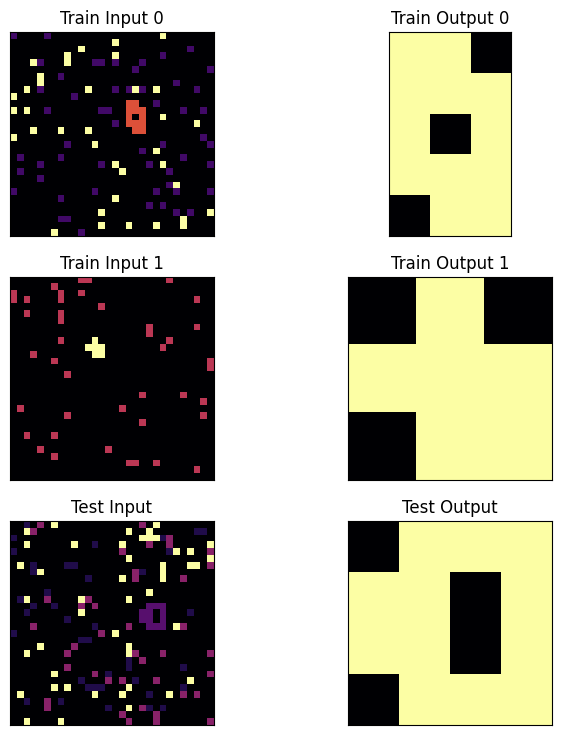

In [4]:
# import the display_challenge function
from utilities.plot import display_challenge

# find the first challenge and solution
challenge_key = '1f85a75f'
first_challenge = training_challenge_dict[challenge_key]
first_solution = training_solutions_dict[challenge_key]

# display the challenge
display_challenge(challenge_key)

In [5]:
# import transformation functions
from utilities.transform import transpose, rotate, delete_cell, alt_drag, flip, crop

transpose_try = transpose
rotate_try = rotate
delete_cell_try = delete_cell
alt_drag_try = alt_drag
flip_try = flip

kwargs = [{'pos1' : 1, 'pos2' : 8}]
#kwargs = kwargs[2:]
print(kwargs)

transformations = [crop]

# plot the transformed challenge
#display_challenge(challenge_key, transformations=transformations, kwargs=kwargs)

[{'pos1': 1, 'pos2': 8}]


random key: 007bbfb7
[[0, 7, 7], [7, 7, 7], [0, 7, 7]]
[[4, 0, 4], [0, 0, 0], [0, 4, 0]]
[[0, 0, 0], [0, 0, 2], [2, 0, 2]]
[[6, 6, 0], [6, 0, 0], [0, 6, 6]]
[[2, 2, 2], [0, 0, 0], [0, 2, 2]]


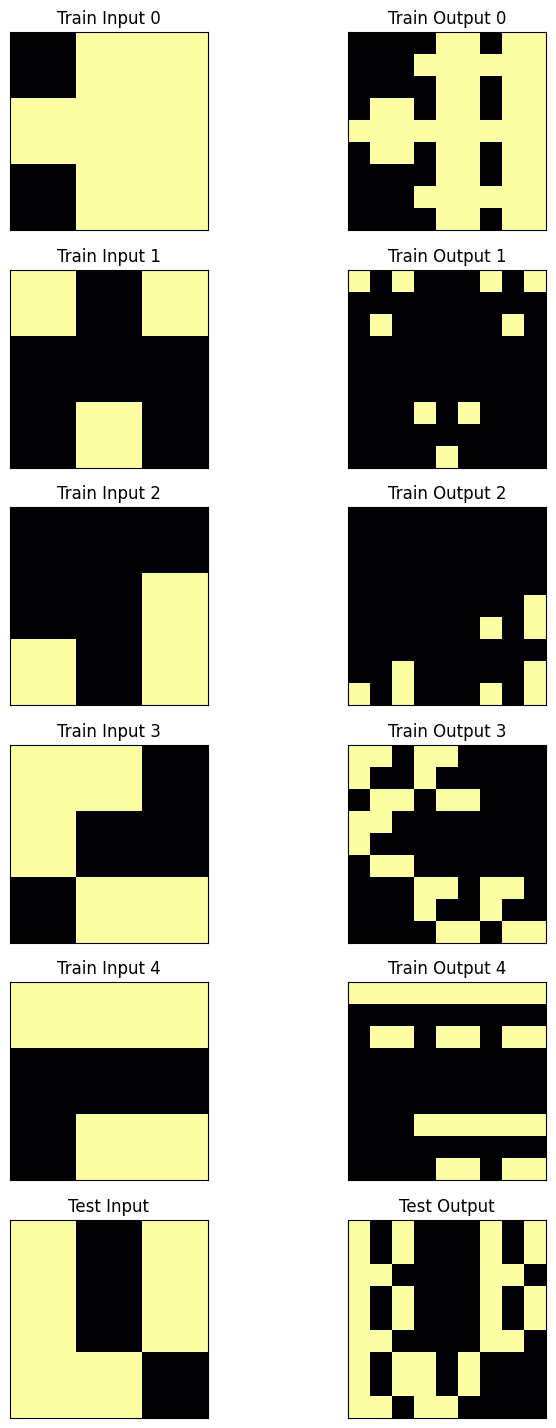

i1, j1: 0 1
i2, j2: 2 2
original array: [[0 7 7]
 [7 7 7]
 [0 7 7]]
cropped array: [[7 7]
 [7 7]
 [7 7]]
i1, j1: 0 1
i2, j2: 0 8
original array: [[0 0 0 0 7 7 0 7 7]
 [0 0 0 7 7 7 7 7 7]
 [0 0 0 0 7 7 0 7 7]
 [0 7 7 0 7 7 0 7 7]
 [7 7 7 7 7 7 7 7 7]
 [0 7 7 0 7 7 0 7 7]
 [0 0 0 0 7 7 0 7 7]
 [0 0 0 7 7 7 7 7 7]
 [0 0 0 0 7 7 0 7 7]]
cropped array: [[0 0 0 7 7 0 7 7]]
[[7 7]
 [7 7]
 [7 7]]
i1, j1: 0 1
i2, j2: 2 2
original array: [[4 0 4]
 [0 0 0]
 [0 4 0]]
cropped array: [[0 4]
 [0 0]
 [4 0]]
i1, j1: 0 1
i2, j2: 0 8
original array: [[4 0 4 0 0 0 4 0 4]
 [0 0 0 0 0 0 0 0 0]
 [0 4 0 0 0 0 0 4 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 4 0 4 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 4 0 0 0 0]]
cropped array: [[0 4 0 0 0 4 0 4]]
[[0 4]
 [0 0]
 [4 0]]
i1, j1: 0 1
i2, j2: 2 2
original array: [[0 0 0]
 [0 0 2]
 [2 0 2]]
cropped array: [[0 0]
 [0 2]
 [0 2]]
i1, j1: 0 1
i2, j2: 0 8
original array: [[0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 

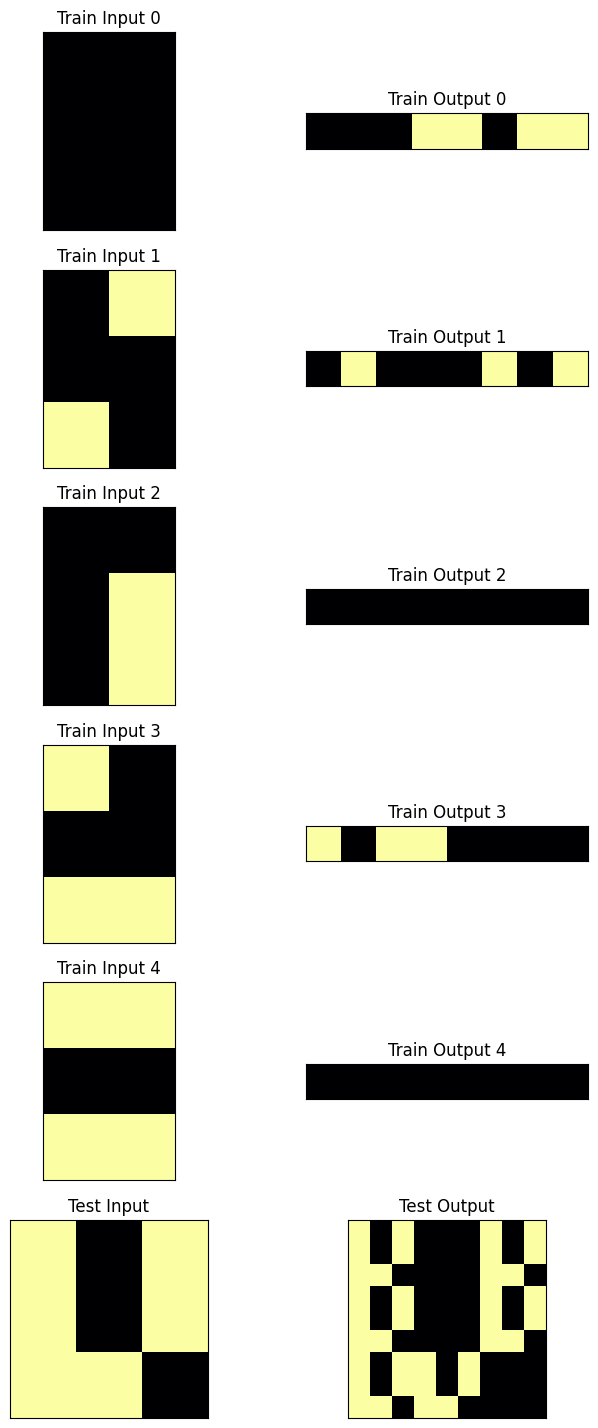

random key: 00d62c1b
[[0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0], [0, 3, 0, 3, 0, 0], [0, 0, 3, 0, 3, 0], [0, 0, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 0, 3, 0, 0, 0, 0, 0], [0, 0, 0, 3, 0, 3, 0, 0, 0, 0], [0, 0, 3, 0, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 0, 3, 0, 3, 0, 0], [0, 0, 0, 3, 0, 3, 3, 0, 0, 0], [0, 0, 3, 3, 3, 0, 0, 0, 0, 0], [0, 0, 0, 3, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 3, 0, 0, 0, 0], [0, 0, 0, 0, 3, 0, 0, 0, 0, 0], [0, 3, 3, 0, 3, 3, 0, 3, 0, 0], [3, 0, 0, 3, 0, 0, 3, 0, 3, 0], [0, 0, 0, 3, 0, 0, 3, 3, 0, 0], [0, 0, 0, 3, 0, 0, 3, 0, 0, 0], [0, 0, 0, 3, 0, 0, 3, 0, 0, 0], [0, 0, 0, 0, 3, 3, 0, 3, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 3, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 3, 3, 3, 3, 0, 0, 0, 0], [0, 0, 3, 0, 0, 3, 0, 0, 0, 0], [0, 0, 3, 0, 0, 3, 0, 3, 0, 0], [0, 0, 3, 3, 3, 3, 3, 3, 3, 0], [0, 0, 0, 3, 0, 0, 0, 0, 3, 0], [0, 0, 0, 3, 0, 0, 0, 3

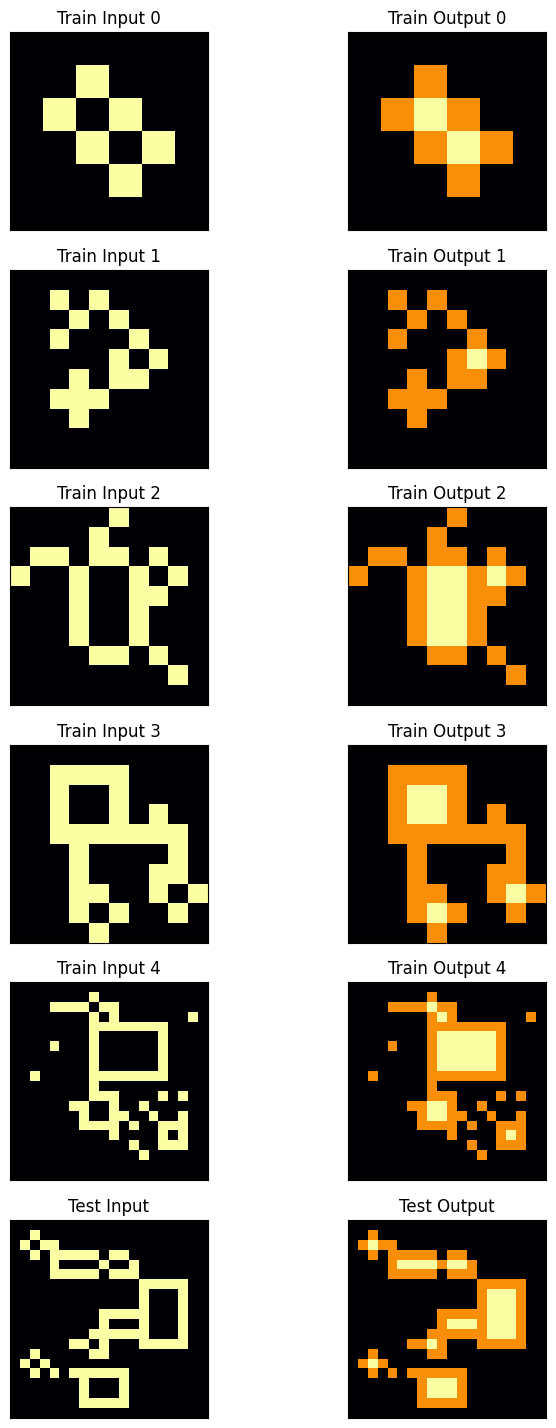

i1, j1: 0 1
i2, j2: 1 2
original array: [[0 0 0 0 0 0]
 [0 0 3 0 0 0]
 [0 3 0 3 0 0]
 [0 0 3 0 3 0]
 [0 0 0 3 0 0]
 [0 0 0 0 0 0]]
cropped array: [[0 0]
 [0 3]]
i1, j1: 0 1
i2, j2: 1 2
original array: [[0 0 0 0 0 0]
 [0 0 3 0 0 0]
 [0 3 4 3 0 0]
 [0 0 3 4 3 0]
 [0 0 0 3 0 0]
 [0 0 0 0 0 0]]
cropped array: [[0 0]
 [0 3]]
[[0 0]
 [0 3]]
i1, j1: 0 1
i2, j2: 0 8
original array: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 3 0 0 0 0 0]
 [0 0 0 3 0 3 0 0 0 0]
 [0 0 3 0 0 0 3 0 0 0]
 [0 0 0 0 0 3 0 3 0 0]
 [0 0 0 3 0 3 3 0 0 0]
 [0 0 3 3 3 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
cropped array: [[0 0 0 0 0 0 0 0]]
i1, j1: 0 1
i2, j2: 0 8
original array: [[0 0 0 0 0 0 0 0 0 0]
 [0 0 3 0 3 0 0 0 0 0]
 [0 0 0 3 0 3 0 0 0 0]
 [0 0 3 0 0 0 3 0 0 0]
 [0 0 0 0 0 3 4 3 0 0]
 [0 0 0 3 0 3 3 0 0 0]
 [0 0 3 3 3 0 0 0 0 0]
 [0 0 0 3 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0]]
cropped array: [[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
i1, j1: 0 1
i2, j2: 0 8
origina

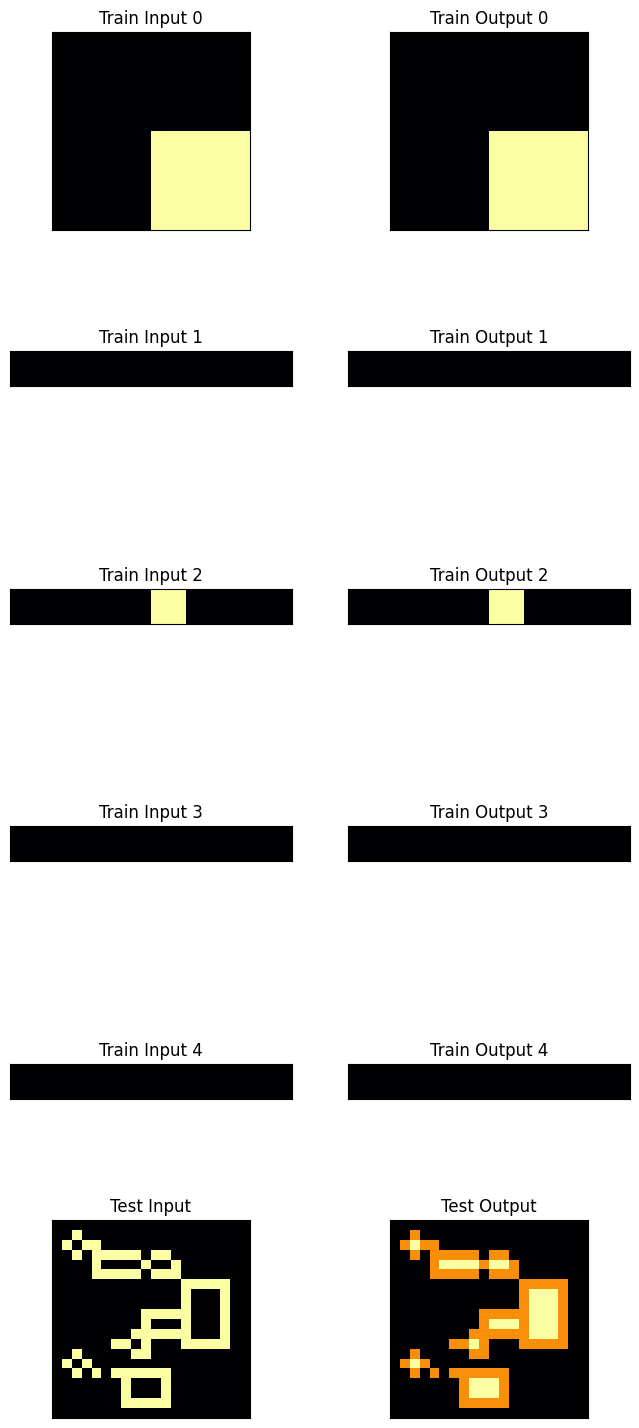

random key: 017c7c7b
[[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 1], [0, 1, 0], [1, 1, 0]]
[[0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1], [0, 1, 0], [1, 0, 1]]
[[0, 1, 0], [1, 1, 0], [0, 1, 0], [0, 1, 0], [1, 1, 0], [0, 1, 0]]


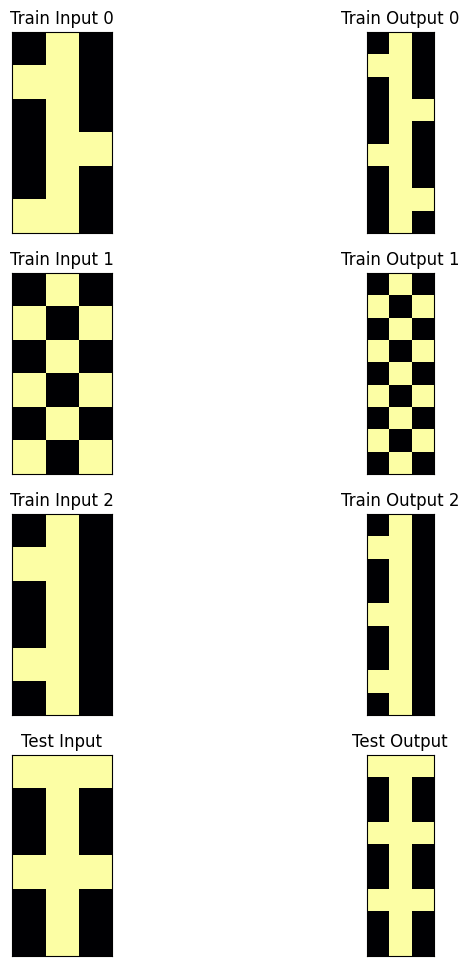

i1, j1: 0 1
i2, j2: 2 2
original array: [[0 1 0]
 [1 1 0]
 [0 1 0]
 [0 1 1]
 [0 1 0]
 [1 1 0]]
cropped array: [[1 0]
 [1 0]
 [1 0]]
i1, j1: 0 1
i2, j2: 2 2
original array: [[0 2 0]
 [2 2 0]
 [0 2 0]
 [0 2 2]
 [0 2 0]
 [2 2 0]
 [0 2 0]
 [0 2 2]
 [0 2 0]]
cropped array: [[2 0]
 [2 0]
 [2 0]]
[[1 0]
 [1 0]
 [1 0]]
i1, j1: 0 1
i2, j2: 2 2
original array: [[0 1 0]
 [1 0 1]
 [0 1 0]
 [1 0 1]
 [0 1 0]
 [1 0 1]]
cropped array: [[1 0]
 [0 1]
 [1 0]]
i1, j1: 0 1
i2, j2: 2 2
original array: [[0 2 0]
 [2 0 2]
 [0 2 0]
 [2 0 2]
 [0 2 0]
 [2 0 2]
 [0 2 0]
 [2 0 2]
 [0 2 0]]
cropped array: [[2 0]
 [0 2]
 [2 0]]
[[1 0]
 [0 1]
 [1 0]]
i1, j1: 0 1
i2, j2: 2 2
original array: [[0 1 0]
 [1 1 0]
 [0 1 0]
 [0 1 0]
 [1 1 0]
 [0 1 0]]
cropped array: [[1 0]
 [1 0]
 [1 0]]
i1, j1: 0 1
i2, j2: 2 2
original array: [[0 2 0]
 [2 2 0]
 [0 2 0]
 [0 2 0]
 [2 2 0]
 [0 2 0]
 [0 2 0]
 [2 2 0]
 [0 2 0]]
cropped array: [[2 0]
 [2 0]
 [2 0]]
[[1 0]
 [1 0]
 [1 0]]


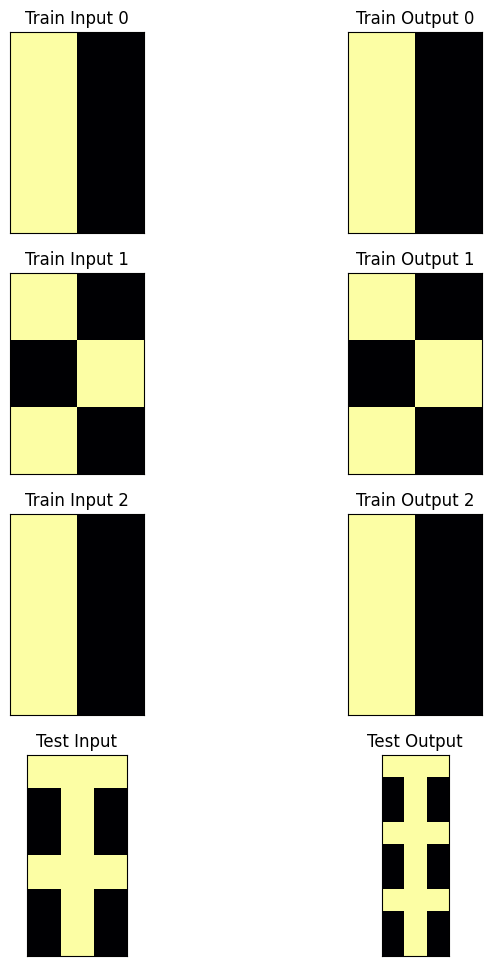

random key: 025d127b
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 6, 6, 6, 0, 0, 0, 0, 0], [0, 6, 0, 0, 6, 0, 0, 0, 0], [0, 0, 6, 0, 0, 6, 0, 0, 0], [0, 0, 0, 6, 0, 0, 6, 0, 0], [0, 0, 0, 0, 6, 6, 6, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 2, 2, 2, 0, 0, 0, 0], [0, 0, 2, 0, 0, 2, 0, 0, 0], [0, 0, 0, 2, 2, 2, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]
[[0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 8, 8, 8, 8, 8, 0, 0, 0], [0, 8, 0, 0, 0, 0, 8, 0, 0], [0, 0, 8, 0, 0, 0, 0, 8, 0], [0, 0, 0, 8, 0, 0, 0, 0, 8], [0, 0, 0, 0, 8, 8, 8, 8, 8], [0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0]]


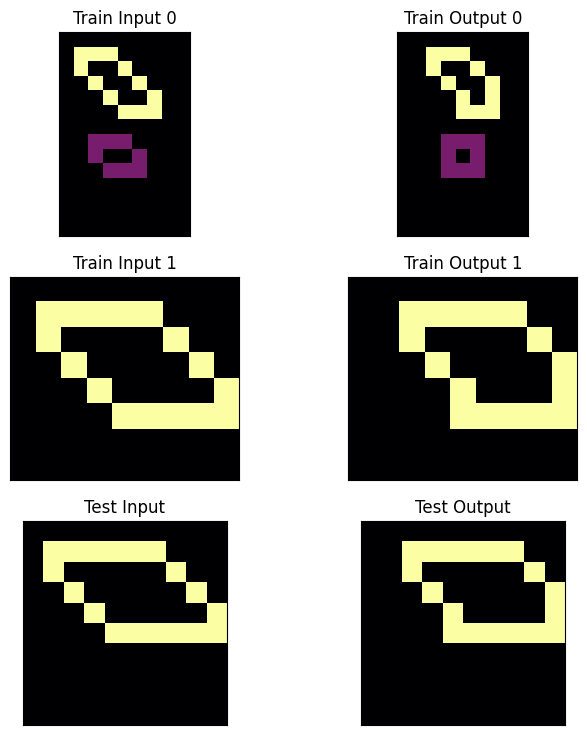

i1, j1: 0 1
i2, j2: 0 8
original array: [[0 0 0 0 0 0 0 0 0]
 [0 6 6 6 0 0 0 0 0]
 [0 6 0 0 6 0 0 0 0]
 [0 0 6 0 0 6 0 0 0]
 [0 0 0 6 0 0 6 0 0]
 [0 0 0 0 6 6 6 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 2 2 2 0 0 0 0]
 [0 0 2 0 0 2 0 0 0]
 [0 0 0 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
cropped array: [[0 0 0 0 0 0 0 0]]
i1, j1: 0 1
i2, j2: 0 8
original array: [[0 0 0 0 0 0 0 0 0]
 [0 0 6 6 6 0 0 0 0]
 [0 0 6 0 0 6 0 0 0]
 [0 0 0 6 0 0 6 0 0]
 [0 0 0 0 6 0 6 0 0]
 [0 0 0 0 6 6 6 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 2 2 2 0 0 0]
 [0 0 0 2 0 2 0 0 0]
 [0 0 0 2 2 2 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
cropped array: [[0 0 0 0 0 0 0 0]]
[[0 0 0 0 0 0 0 0]]
i1, j1: 0 1
i2, j2: 0 8
original array: [[0 0 0 0 0 0 0 0 0]
 [0 8 8 8 8 8 0 0 0]
 [0 8 0 0 0 0 8 0 0]
 [0 0 8 0 0 0 0 8 0]
 [0 0 0 8 0 0 0 0 8]
 [0 0 0 0 8 8 8 8 8]
 [0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0]]
cropped array: [[0 0 0 0 0 0 0 

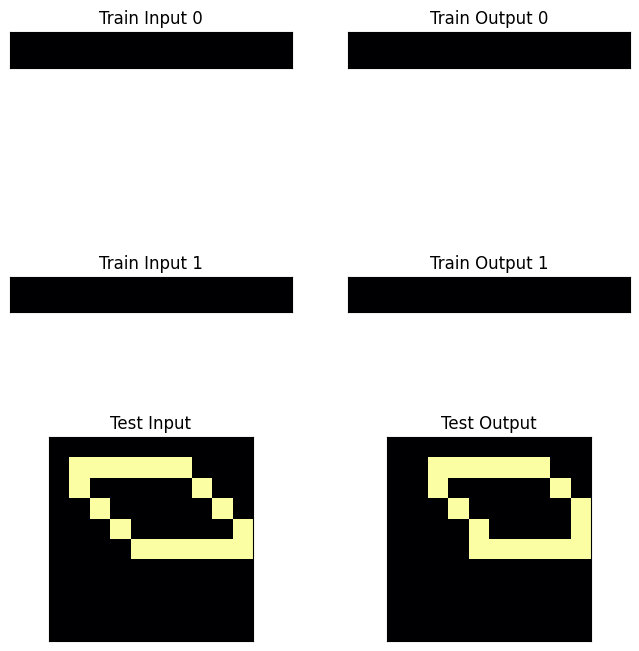

random key: 045e512c
[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 8, 8, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 8, 0, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 8, 8, 8, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0,

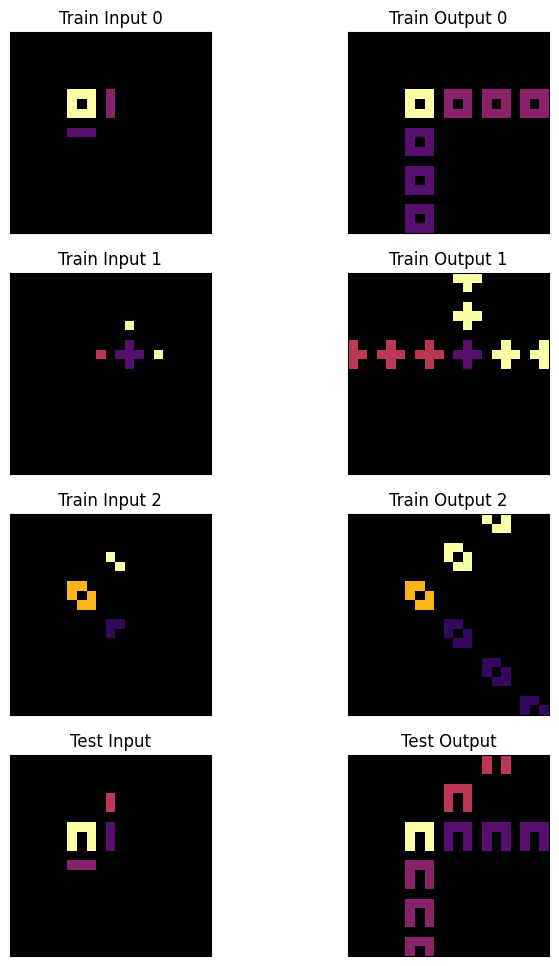

i1, j1: 0 1
i2, j2: 0 8
original array: [[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 8 8 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 0 8 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 8 8 8 0 3 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 2 2 2 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]
cropped array:

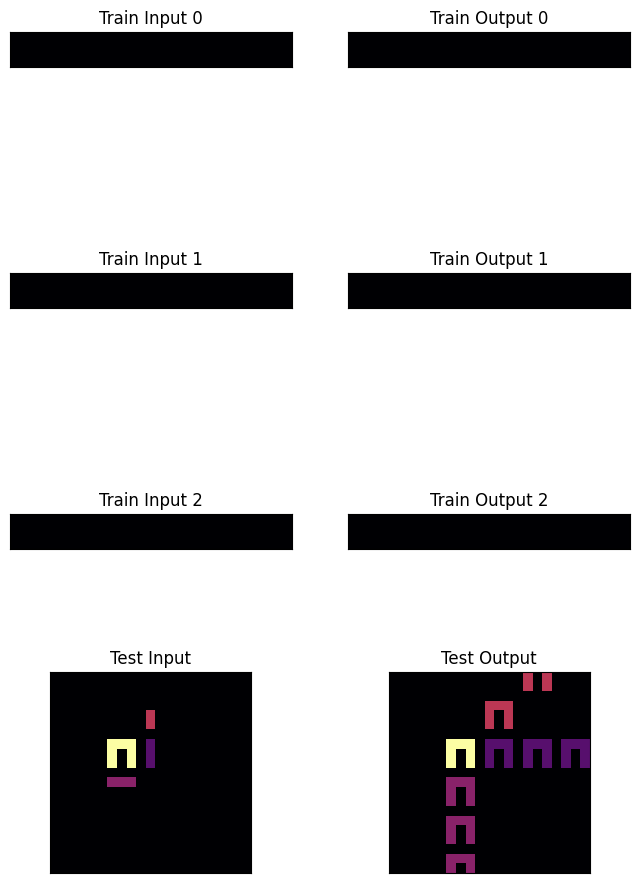

In [6]:
# plot n random transformations
n = 5
for i in range(n):
    key = random_keys[i]
    print('random key:', key)
    display_challenge(key, kwargs=kwargs)
    display_challenge(key, transformations=transformations, kwargs=kwargs)